In [23]:
import sys
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import os
import matplotlib.pyplot as plt
import numpy as np
import ot
import time
import numba

from skimage.io import imread,imsave
from skimage.segmentation import slic
from sklearn.cluster import KMeans
import torch
import torch.optim as optim
from skimage.segmentation import slic
import numba 

parent_path='/home/baly/projects/sliced_opt'
sys.path.append(parent_path)
os.chdir(parent_path)
from sopt.library import *
from sopt.lib_ot import *   
from sopt.sliced_opt import *  
from sopt.lib_color import * 

from scipy.interpolate import CubicSplinev

/home/baly/projects/sliced_opt/sopt/sliced_opt.py:78: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  X_theta=np.dot(theta,X.T)
/home/baly/projects/sliced_opt/sopt/sliced_opt.py:133: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  X_projections=projections.dot(X.T)
/home/baly/projects/sliced_opt/sopt/lib_color.py:131: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  Xs=np.dot(cond_plan,Xt)


ImportError: cannot import name 'CubicSplinev' from 'scipy.interpolate' (/home/baly/miniconda3/envs/general/lib/python3.11/site-packages/scipy/interpolate/__init__.py)

In [ ]:
# Parameters for the first Gaussian distribution
mean1 = -6
variance1 = 1.3

# Parameters for the second Gaussian distribution
mean2 = 6
variance2 = 1.5

# Generate x values
x1 = np.linspace(mean1-3*np.sqrt(variance1), mean1+3*np.sqrt(variance1), 500)
x2 = np.linspace(mean2-3*np.sqrt(variance2), mean2+3*np.sqrt(variance2), 500)

# Compute y values for the first Gaussian distribution
y1 = np.exp(-0.5 * ((x1 - mean1) / np.sqrt(variance1))**2)
y1 /= np.sqrt(2 * np.pi * variance1)

# Compute y values for the second Gaussian distribution
y2 = np.exp(-0.5 * ((x2 - mean2) / np.sqrt(variance2))**2)
y2 /= np.sqrt(2 * np.pi * variance2)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 3))

ax.fill_between(x1, y1, color='pink', alpha=0.5)
ax.fill_between(x2, y2, color='gray', alpha=0.5)

# Draw points
ax.plot(-6, 0.1,  'ro', markersize=5)
ax.text(-5.9, 0.065, '$x^0$', ha='center', va='bottom', fontsize=12)
ax.text(-6, 0.3, '$\mu^0$', ha='center', va='bottom', fontsize=12)


ax.plot(6, 0.1, 'bo', markersize=5)
ax.text(6.1, 0.065, '$x^j$', ha='center', va='bottom', fontsize=12)
ax.text(6, 0.28, '$\mu^j$', ha='center', va='bottom', fontsize=12)

arc_x = np.linspace(-6, 6, 100)

# Define the x and y coordinates of the given points
x_points = [-6, 0, 6]
y_points = [0.1, 0.2, 0.1]
# Create a cubic spline interpolation function
interpolation = CubicSpline(x_points, y_points)
arc_y = interpolation(arc_x)
# Plot the smooth function
plt.plot(arc_x, arc_y, color='green',linewidth=1.0,alpha=0.5)
ax.text(0, 0.2, '$\|x^0-x^j\|^2$', ha='center', va='bottom', fontsize=12)



# # Draw the smooth curve c(x, y)
# curve_x = np.linspace(-6, 6, 100)
# curve_y = np.exp(-0.5 * ((curve_x - mean_1) / np.sqrt(variance_1))**2) / (np.sqrt(2 * np.pi * variance_1))
# curve_y += np.exp(-0.5 * ((curve_x - mean_2) / np.sqrt(variance_2))**2) / (np.sqrt(2 * np.pi * variance_2))
# ax.plot(curve_x, curve_y, 'g-', linewidth=2)

# plt.xlabel('x')
# plt.ylabel('Probability density')
# plt.title('Gaussian Distributions')
# plt.legend(['Distribution 1', 'Distribution 2'])
# plt.grid(True)

# Set the x and y axis limits to make the two shapes disjoint
plt.xlim(-10, 10)
plt.ylim(0, max(max(y1), max(y2)) + 0.05)
plt.axis('off')
plt.savefig('ot_plot.pdf',dpi=200, bbox_inches='tight')

# Display the plot
plt.show()

In [ ]:
# Parameters for the first Gaussian distribution
mean1 = -6
variance1 = 1.3

# Parameters for the second Gaussian distribution
mean2 = 6
variance2 = 1.5

# Generate x values
x1 = np.linspace(mean1-3*np.sqrt(variance1), mean1+3*np.sqrt(variance1), 500)
x2 = np.linspace(mean2-3*np.sqrt(variance2), mean2+3*np.sqrt(variance2), 500)

# Compute y values for the first Gaussian distribution
y1 = np.exp(-0.5 * ((x1 - mean1) / np.sqrt(variance1))**2)
y1 /= np.sqrt(2 * np.pi * variance1)

# Compute y values for the second Gaussian distribution
y2 = np.exp(-0.5 * ((x2 - mean2) / np.sqrt(variance2))**2)
y2 /= np.sqrt(2 * np.pi * variance2)*0.85

# Create the plot
fig, ax = plt.subplots(figsize=(8, 3))

ax.fill_between(x1, y1, color='pink', alpha=0.5)
ax.fill_between(x2, y2, color='lightblue', alpha=0.5)
ax.fill_between(x1[x1<=mean1-1.2], y1[x1<=mean1-1.2], alpha=0.2, color='r')
ax.fill_between(x2[x2>=mean2+1.2], y2[x2>=mean2+1.2], alpha=0.2, color='b')

ax.text(-8.1, 0., '$\mu^0-\gamma_0$', ha='center', va='bottom', fontsize=12)
ax.text(-5, 0., '$\gamma_0$', ha='center', va='bottom', fontsize=12)
ax.text(8.2, 0., '$\mu^j-\gamma_1$', ha='center', va='bottom', fontsize=12)
ax.text(5, 0., '$\gamma_1$', ha='center', va='bottom', fontsize=12)



# Draw points
ax.plot(-6, 0.1,  'ro', markersize=5)
ax.text(-5.9, 0.065, '$x^0$', ha='center', va='bottom', fontsize=12)
ax.text(-6, 0.3, '$\mu^0$', ha='center', va='bottom', fontsize=12)


ax.plot(6, 0.1, 'bo', markersize=5)
ax.text(6.1, 0.065, '$x^j$', ha='center', va='bottom', fontsize=12)
ax.text(6, 0.28, '$\mu^j$', ha='center', va='bottom', fontsize=12)

arc_x = np.linspace(-6, 6, 100)

# Define the x and y coordinates of the given points
x_points = [-6, 0, 6]
y_points = [0.1, 0.2, 0.1]
# Create a cubic spline interpolation function
interpolation = CubicSpline(x_points, y_points)
arc_y = interpolation(arc_x)
# Plot the smooth function
plt.plot(arc_x, arc_y, color='green',linewidth=1.0,alpha=0.5)
ax.text(0, 0.2, '$\|x^0-x^j\|^2$', ha='center', va='bottom', fontsize=12)




# Set the x and y axis limits to make the two shapes disjoint
plt.xlim(-10, 10)
plt.ylim(0, max(max(y1), max(y2)) + 0.05)
plt.axis('off')
plt.savefig('opt_plot.pdf', bbox_inches='tight')

# Display the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Create a new figure and axis
fig, ax = plt.subplots()

# Define the y-values of the parallel horizontal lines
y1, y2 = 3, 1

# Draw two parallel horizontal lines
ax.hlines(y=y1, xmin=0, xmax=10, color='black')
ax.hlines(y=y2, xmin=0, xmax=10, color='black')

# Choose points xi and yj
xi = 4  # Example x-coordinate for the orange point
yj = 7  # Example x-coordinate for the blue point

# Draw the points xi and yj on the respective lines
ax.scatter(xi, y1, color='orange')
ax.scatter(yj, y2, color='blue')

# Connect the points xi and yj
ax.plot([xi, yj], [y1, y2], color='grey', linestyle='--')

# Annotate points and line
offset = 0.1  # Offset for placing the annotations away from the points and line
ax.text(xi, y1 + offset, '$x_i$',size=15, ha='center', va='center', color='black')
ax.text(yj, y2 - offset, '$y_j$',size=15, ha='center', va='center', color='black')
ax.text((xi+yj)/2-offset, (y1+y2)/2,  '$c(x_i,y_j)$',size=15, ha='center', va='center', color='grey')
plt.axis('off')
# Display the plot
fig.savefig('ppt/lambda_case0.png', bbox_inches='tight')
fig.savefig('ppt/lambda_case0.pdf', bbox_inches='tight')
plt.show()


In [22]:
# Create a new figure and axis
fig, ax = plt.subplots()
plt.rcParams['text.usetex'] = True
# Define the y-values of the parallel horizontal lines
y1, y2 = 3, 1

# Draw two parallel horizontal lines
ax.hlines(y=y1, xmin=0, xmax=10, color='black')
ax.hlines(y=y2, xmin=0, xmax=10, color='black')

# Choose points xi and yj
xi = 4  # Example x-coordinate for the orange point
yj = 7  # Example x-coordinate for the blue point

# Draw the points xi and yj on the respective lines
ax.scatter(xi, y1, color='orange')
ax.scatter(yj, y2, color='blue')

# Connect the points xi and yj
ax.plot([xi, yj], [y1, y2], color='grey', linestyle='--')

# Annotate points and line
offset = 0.1  # Offset for placing the annotations away from the points and line
ax.text(xi, y1 + offset, r'$\cancel{x_i}$',size=15, ha='center', va='center', color='black')
ax.text(yj, y2 - offset, '$y_j$',size=15, ha='center', va='center', color='black')
ax.text((xi+yj)/2-offset, (y1+y2)/2,  '$c(x_i,y_j)$',size=15, ha='center', va='center', color='grey')
plt.axis('off')
# Display the plot
#fig.savefig('ppt/lambda_case0.png', bbox_inches='tight')
#fig.savefig('ppt/lambda_case0.pdf', bbox_inches='tight')
plt.show()


RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 640x480 with 1 Axes>

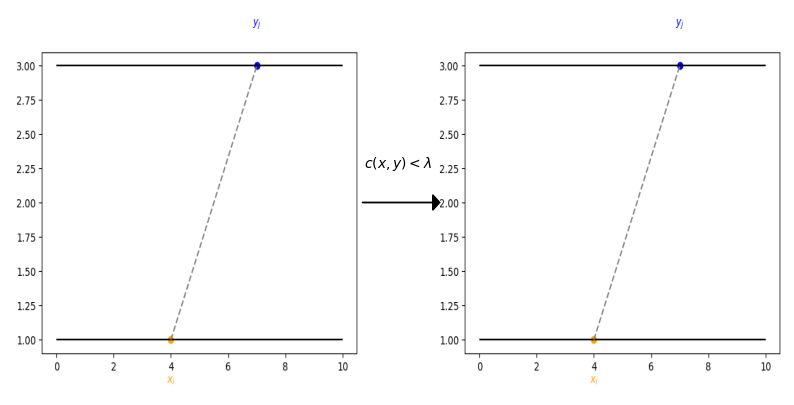

In [12]:


# Combine image1 and image2 side-by-side with an arrow and text in between
fig_combined, ax_combined = plt.subplots(figsize=(10, 5))
ax_combined.axis('off')

# Display the images
img1 = mpimg.imread('image1.png')
img2 = mpimg.imread('image2.png')
ax_combined.imshow(img1, extent=[0, 10, 0, 5], aspect='auto')
ax_combined.imshow(img2, extent=[12, 22, 0, 5], aspect='auto')

# Draw arrow
arrow_x_start, arrow_x_end = 10, 12
arrow_y = 2.5
ax_combined.arrow(arrow_x_start, arrow_y, arrow_x_end - arrow_x_start, 0,
                  head_width=0.2, head_length=0.2, fc='black', ec='black')

# Add text above the arrow
ax_combined.text((arrow_x_start + arrow_x_end) / 2, arrow_y + 0.5, "$c(x,y)<\lambda$",
                 ha='center', va='center', color='black')

# Show combined figure
plt.show()

In [21]:
import matplotlib.pyplot as plt

def draw_crossed_out_figure():
    fig, ax = plt.subplots()

    # Define the y-values of the parallel horizontal lines
    y1, y2 = 1, 3

    # Draw two parallel horizontal lines
    ax.hlines(y=y1, xmin=0, xmax=10, color='black')
    ax.hlines(y=y2, xmin=0, xmax=10, color='black')

    # Choose points xi and yj
    xi = 4  # Example x-coordinate for the orange point
    yj = 7  # Example x-coordinate for the blue point

    # Draw the points xi and yj on the respective lines
    ax.scatter(xi, y1, color='orange')
    ax.scatter(yj, y2, color='blue')

    # Connect the points xi and yj
    ax.plot([xi, yj], [y1, y2], color='grey', linestyle='--')

    # Annotate points and line
    offset = 0.3  # Offset for placing the annotations away from the points and line
    ax.text(xi, y1 - offset, r'$\cancel{x_i}$', ha='center', va='center', color='orange', fontsize=14)
    ax.text(yj, y2 + offset, '$y_j$', ha='center', va='center', color='blue')

    plt.show()

# Display the figure
draw_crossed_out_figure()

ValueError: 
\cancel{x_i}
^
ParseFatalException: Expected token, found '\'  (at char 0), (line:1, col:1)

<Figure size 640x480 with 1 Axes>